In [1]:
import src.SessionProcessor as SessionProcessor
import numpy as np
import xarray
import copy
import pdb
from numpy.random import default_rng
import matplotlib
import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

def compare_elements(arr1, arr2):
        arr1 = arr1.flat
        arr2 = arr2.flat
        num_elements = len(arr1)
        
        # If there are the same number of elements in both arrays, check that the arrays have identical elements
        if num_elements == len(arr2):
            for idx in range(num_elements):
                if arr1[idx] != arr2[idx]:
                    return False
        else:
            return False
        
        return True

def assertFalse(arg):
    if arg:
        raise AssertionError()

def assertTrue(arg):
    if not(arg):
        raise AssertionError()


c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\allensdk\brain_observatory\comparison_utils.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Everything here is required to correctly load a session object. Session objects take a while
# to load (a touch over a minute on my machine), so only one session is loaded to make the tests
# go faster.
# It'll take a couple minutes to run these tests, even though there aren't many, because of the
# session object.
data_root = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab"
manifest_path = f"{data_root}/AllenSDK_Data/manifest.json"
stim = 'drifting_gratings_contrast'
session_id = 778240327
cache = EcephysProjectCache(manifest=manifest_path)
session = cache.get_session_data(session_id=session_id)
stim_table = session.get_stimulus_table("drifting_gratings_contrast")
stim_ids = stim_table.index.values

# All the units in one convenient spot
all_units = []
units_by_acronym = {}
for acronym in session.structure_acronyms:
    # Because self.all_units is constantly growing, this will change every iteration
    current = list(
        session.units[session.units.ecephys_structure_acronym == acronym].index
    )

    units_by_acronym[acronym] = current
    all_units = all_units + current


# We're comparing shuffled and unshuffled PSTH data, so we need a shuffled and unshuffled version
# of the session
processor = SessionProcessor.SessionProcessor(session)
unshuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation')
shuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation', shuffle_trials=True)

In [3]:
# The PSTHs I'm refering to here are each cell's spike count after a stim presentation.
# For both shuffled and unshuffled trials, those are stored in:
# processor._decoders[name].x
unshuffled_x = processor._decoders[unshuffled].x
unshuffled_y = processor._decoders[unshuffled].y
shuffled_x = processor._decoders[shuffled].x
print(f"unshuffled_x.shape = {unshuffled_x.shape}")
print(f"unshuffled_y.shape = {unshuffled_y.shape}")
print(f"shuffled_x.shape = {shuffled_x.shape}")
print(f"axis 0 shape: {unshuffled_x.mean(axis=0).shape}")
print(f"axis 1 shape: {unshuffled_x.mean(axis=1).shape}")
print(f"axis 2 shape: {unshuffled_x.mean(axis=2).shape}")

try:
    assertFalse(compare_elements(unshuffled_x, shuffled_x))
    print("The data is being shuffled")
except AssertionError as e:
    print("The data is not being shuffled")

try:
    # PSTHs should be averaged over presentation, which should be axis=0
    # num_presentations, num_bins, num_units = x.shape
    assertTrue(compare_elements(unshuffled_x.mean(axis=0), shuffled_x.mean(axis=0)))
    print("The trial averaged PSTHs of the shuffled and unshuffled data are identical")
except AssertionError as e:
    print("The trial averaged PSTHs of the shuffled and unshuffled data are NOT identical")

unshuffled_x.shape = (540, 11, 784)
unshuffled_y.shape = (540,)
shuffled_x.shape = (540, 11, 784)
axis 0 shape: (11, 784)
axis 1 shape: (540, 784)
axis 2 shape: (540, 11)
The data is being shuffled
The trial averaged PSTHs of the shuffled and unshuffled data are identical


In [4]:
processor.construct_psth(unshuffled)
processor.construct_psth(shuffled)

processor.calculate_decoder_weights(unshuffled)
processor.calculate_decoder_weights(shuffled)

processor.calculate_correlations(unshuffled)
processor.calculate_correlations(shuffled)

results = processor.results()
unshuffled_results = results[unshuffled]
shuffled_results = results[shuffled]

In [5]:
# For just one stimulus condition, if you 1) put the responses in a numpy array
# and calculate the noise correlation matrix, 2) shuffle the trials and
# calculate the noise correlation matrix from the trial-shuffled responses,
# are the distributions of those two correlations still the same?
#pdb.set_trace()
def correlate_noise(mat):
    # mat: num_presentations x num_units
    num_presentations, num_units = mat.shape
    # Average across the presentations
    expectation = np.array(mat.mean(axis=0))
    variance = np.array(mat.var(axis=0))
    centered_mat = mat-expectation
    covariance = np.dot(centered_mat.T, centered_mat)/num_presentations
    return np.divide(
        covariance,
        np.sqrt(
            np.outer(variance, variance)
            ), 
        out=np.full(covariance.shape, np.nan),
        where=True)
#correlate_noise(unshuffled_sample[:,BIN,:])[upper_triangle_indices].flatten()

rng = default_rng()

bin_start = 0
bin_stop = 0.5
bin_width = 0.05
bin_edges = np.arange(bin_start, bin_stop+bin_width, bin_width)
num_bins = len(bin_edges) - 1

#stim_presentation_order = stim_table.loc[stim_table["orientation"] == COND]
#stim_ids = stim_presentation_order.index.values
#stim_presentation_order = np.array(stim_presentation_order["orientation"])
stim_presentation_order = np.array(stim_table["orientation"])

stim_classes = np.unique(stim_presentation_order)
num_presentations = len(stim_presentation_order)
num_units = len(all_units)
upper_triangle_indices = np.triu_indices(n=num_units, k=1)

all_stim_counts = session.presentationwise_spike_counts(bin_edges, stim_ids, all_units)

# Sort all the stimulus presentation ids by class so that trials are shuffled with
# the correct labels
direct_presentations_by_class = {}
object_unshuffled_presentations_by_class = {}
object_shuffled_presentations_by_class = {}
counts = {}
# For each stimulus condition (e.g. each presentation angle)
for stim_class in stim_classes:
    class_presentation_indicies = []
    class_stim_ids = stim_table.loc[stim_table["orientation"] == stim_class].index.values

    # Collect the indicies for each presentation of that class
    for k in range(num_presentations):
       if stim_class == stim_presentation_order[k]:
           class_presentation_indicies = class_presentation_indicies + [k]

    direct_presentations_by_class[stim_class] = np.array(all_stim_counts[class_presentation_indicies])
    object_unshuffled_presentations_by_class[stim_class] = np.array(processor.presentationwise_spike_counts(unshuffled, bin_edges, class_stim_ids, all_units))
    object_shuffled_presentations_by_class[stim_class] = np.array(processor.presentationwise_spike_counts(shuffled, bin_edges, class_stim_ids, all_units))

direct_unshuffled_presentations_by_class = copy.deepcopy(direct_presentations_by_class)

# PSTHS: (num_presentations, num_bins, num_units)
# We want to loop through each bin -> current_bin: (num_presentations, num_units)
# Shuffle each column of current_bin (keeps units' responses within unit, but outside of trial)
for stim_class in stim_classes:
    # current_class_psth = direct_presentations_by_class[stim_class]
    for bin_idx in range(num_bins):
        for unit_idx in range(num_units):
            rng.shuffle(
                direct_presentations_by_class[stim_class][:, bin_idx, unit_idx]
            )


c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


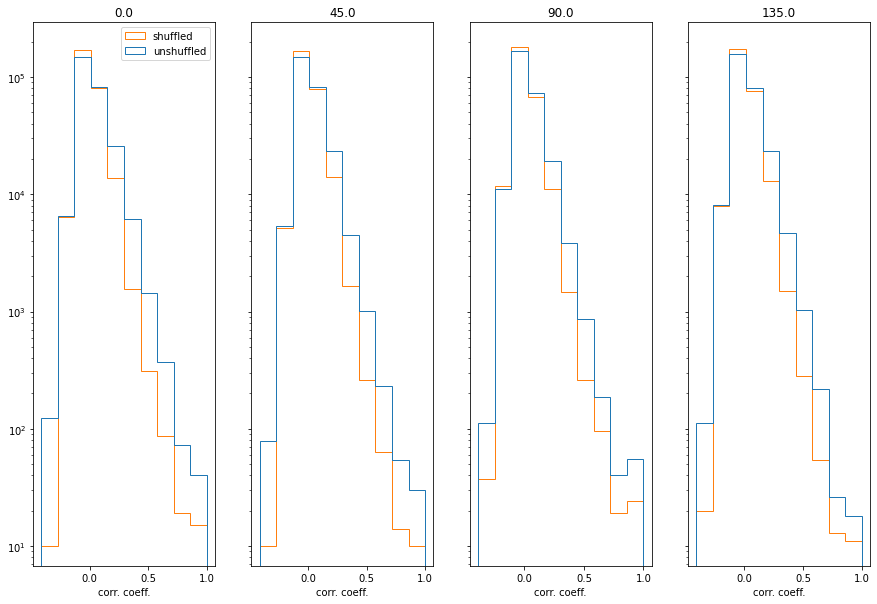

In [6]:
# EXPECTED OUTCOME: 
# Skewed curve smooths out toward a gaussian centered at zero
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (15, 10)
BIN = 2
LOG_SCALE = True
num_stim_classes = len(stim_classes)
hist_collection = [[]]*2
plot_labels = ["unshuffled", "shuffled"]

fig, ax = plt.subplots(nrows=1, ncols=num_stim_classes, sharey=True)
for stim_class, idx in zip(stim_classes, range(num_stim_classes)):
    current_shuffled = direct_presentations_by_class[stim_class]
    current_unshuffled = direct_unshuffled_presentations_by_class[stim_class]
    hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
    hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
    ax[idx].hist(hist_collection, histtype="step", log=LOG_SCALE, label=plot_labels)
    ax[idx].set_title(stim_class)
    
    
    ax[idx].set_xlabel("corr. coeff.")

ax[0].legend()

c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


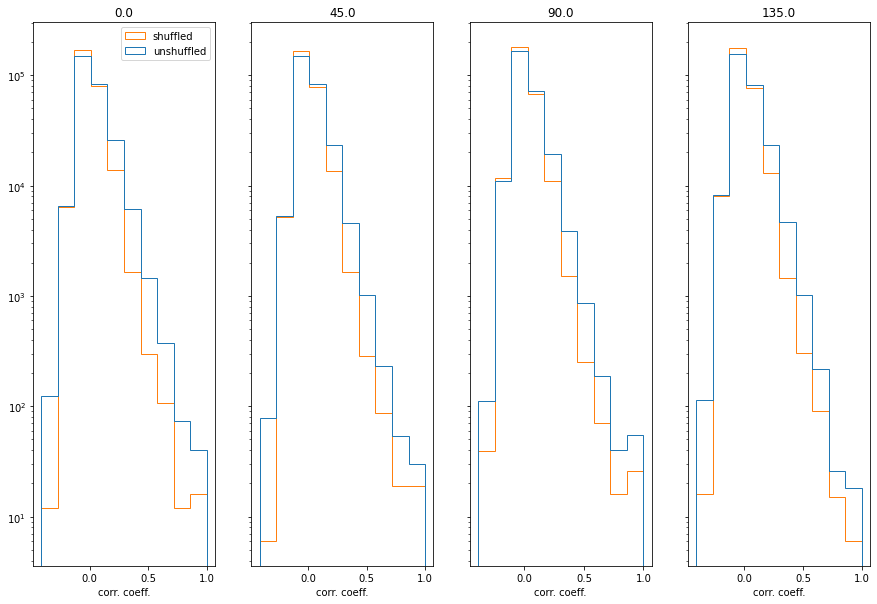

In [7]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (15, 10)

hist_collection = [[]]*2
plot_labels = ["unshuffled", "shuffled"]

fig, ax = plt.subplots(nrows=1, ncols=num_stim_classes, sharey=True)
for stim_class, idx in zip(stim_classes, range(num_stim_classes)):
    current_shuffled = object_shuffled_presentations_by_class[stim_class]
    current_unshuffled = object_unshuffled_presentations_by_class[stim_class]
    hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
    hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
    ax[idx].hist(hist_collection, histtype="step", log=LOG_SCALE, label=plot_labels)
    ax[idx].set_title(stim_class)
    
    
    ax[idx].set_xlabel("corr. coeff.")

ax[0].legend()

c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


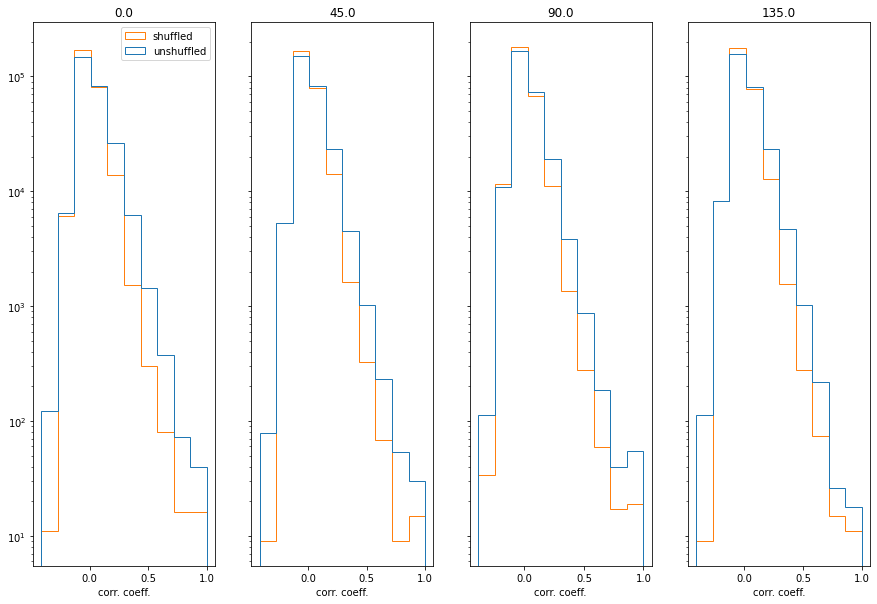

In [13]:
unshuffled_psth = unshuffled_results["class_psths"]["whole"]
shuffled_psth = shuffled_results["class_psths"]["whole"]

fig, ax = plt.subplots(nrows=1, ncols=num_stim_classes, sharey=True)
for stim_class, idx in zip(stim_classes, range(num_stim_classes)):
    current_unshuffled = unshuffled_psth[stim_class]
    current_shuffled = shuffled_psth[stim_class]
    hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
    hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
    ax[idx].hist(hist_collection, histtype="step", log=LOG_SCALE, label=plot_labels)
    ax[idx].set_title(stim_class)
    
    
    ax[idx].set_xlabel("corr. coeff.")

ax[0].legend()

c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


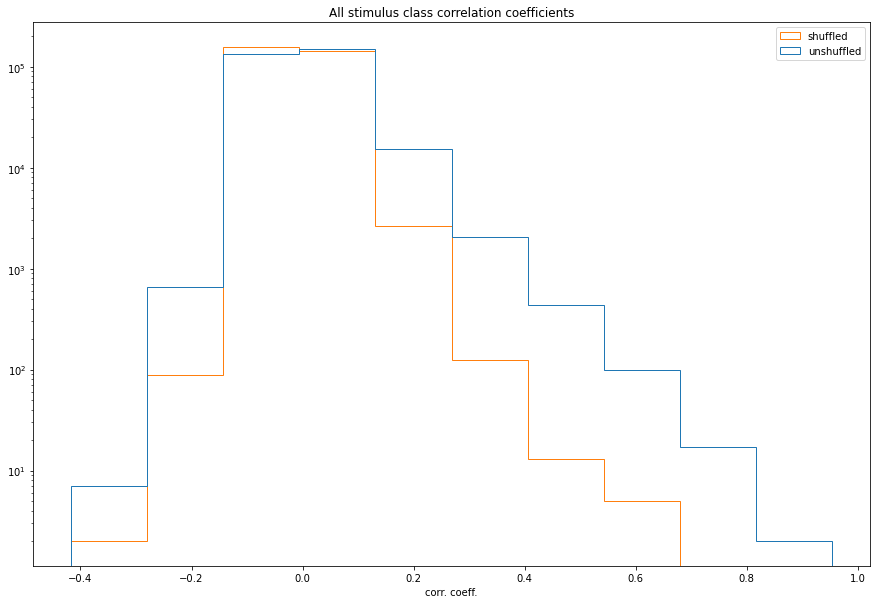

In [15]:
unshuffled_psth = unshuffled_results["psths"]["whole"]
shuffled_psth = shuffled_results["psths"]["whole"]

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
current_unshuffled = unshuffled_psth
current_shuffled = shuffled_psth
hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
ax.hist(hist_collection, histtype="step", log=LOG_SCALE, label=plot_labels)
ax.set_title("All stimulus class correlation coefficients")
ax.set_xlabel("corr. coeff.")
ax.legend()

c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


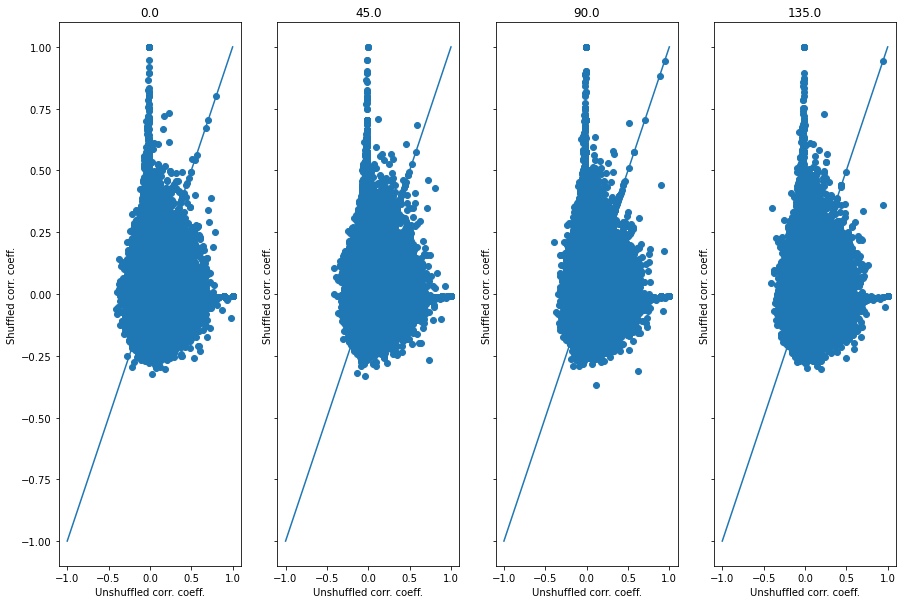

In [8]:
matplotlib.rcParams["figure.figsize"] = (15, 10)

left_bound = -1
right_bound = 1
hist_collection = [[]]*2

fig, ax = plt.subplots(nrows=1, ncols=num_stim_classes, sharex=True, sharey=True)
for stim_class, idx in zip(stim_classes, range(num_stim_classes)):
    current_shuffled = direct_presentations_by_class[stim_class]
    current_unshuffled = direct_unshuffled_presentations_by_class[stim_class]
    x = np.linspace(left_bound, right_bound, num=len(current_unshuffled))
    
    hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
    hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
    ax[idx].scatter(hist_collection[0], hist_collection[1])
    ax[idx].plot(x,x)
    ax[idx].set_title(stim_class)
    ax[idx].set_xlabel("Unshuffled corr. coeff.")
    ax[idx].set_ylabel("Shuffled corr. coeff.")


c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Demogorgon\anaconda3\envs\correlations_and_bursts_env\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


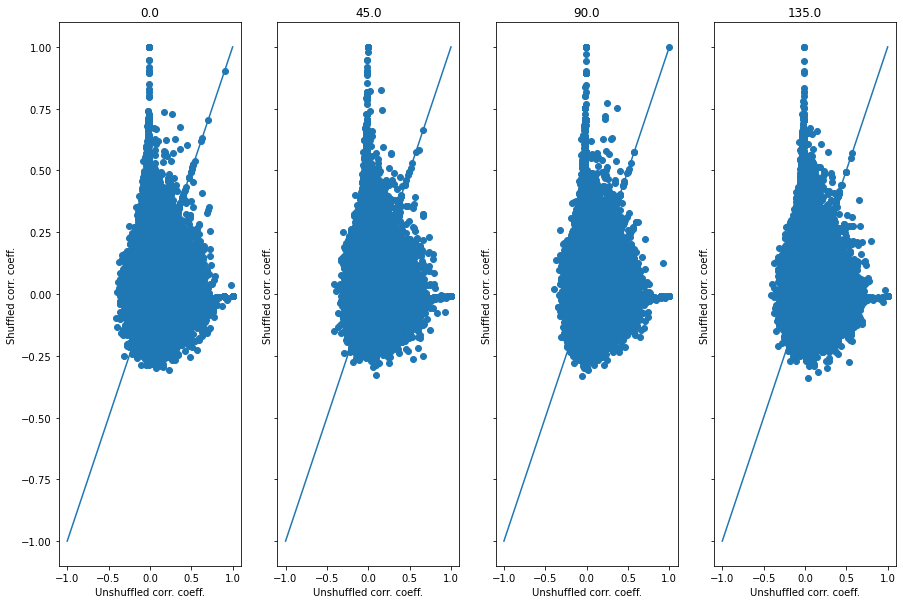

In [9]:
matplotlib.rcParams["figure.figsize"] = (15, 10)

left_bound = -1
right_bound = 1
hist_collection = [[]]*2

fig, ax = plt.subplots(nrows=1, ncols=num_stim_classes, sharex=True, sharey=True)
for stim_class, idx in zip(stim_classes, range(num_stim_classes)):
    current_shuffled = object_shuffled_presentations_by_class[stim_class]
    current_unshuffled = object_unshuffled_presentations_by_class[stim_class]
    x = np.linspace(left_bound, right_bound, num=len(current_unshuffled))
    
    hist_collection[0] = correlate_noise(current_unshuffled[:,BIN,:])[upper_triangle_indices].flatten()
    hist_collection[1] = correlate_noise(current_shuffled[:,BIN,:])[upper_triangle_indices].flatten()
    ax[idx].scatter(hist_collection[0], hist_collection[1])
    ax[idx].plot(x,x)
    ax[idx].set_title(stim_class)
    ax[idx].set_xlabel("Unshuffled corr. coeff.")
    ax[idx].set_ylabel("Shuffled corr. coeff.")
